# Ordinary Least Squares

Single marker linear regression measures how well a genetic variant "**aligns**" with a trait by projecting the trait values onto the variant's genotype direction.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide7.png)

# Key Formula

In the single marker linear regression

$$
\mathbf{Y} = \mathbf{X} \beta + \boldsymbol{\epsilon}
$$

- $\mathbf{Y}$ is the $N \times 1$ vector of trait values for $N$ individuals
- $\mathbf{X}$ is the $N \times 1$ vector of the genotype vector for a single variant across $N$ individuals
- $\beta$ is the scalar representing the effect size for the variant (to be estimated)
- $\boldsymbol{\epsilon} \sim N(\mathbf{0}, \sigma^2)$ is the $N \times 1$ vector of error terms for $N$ individuals

Using **ordinary least squares (OLS)**, we can derive the estimators for $\beta$ as:

$$
\hat{\beta}_{\text{OLS}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y}
$$


# Technical Details

## Genomic Intuition

The OLS estimator has a beautiful geometric interpretation that makes intuitive sense in genomics: OLS measures **how much two vectors align in the same direction** through their inner product, scaled by the variance of $\mathbf{X}$.

**The Inner Product $\mathbf{X}^T\mathbf{Y}$**: This measures the projection of the phenotype vector $\mathbf{Y}$ onto the genotype vector $\mathbf{X}$. In genomic terms, it captures how much the phenotype and genotype "move together" - when genotype values are high, are phenotype values also high? The inner product quantifies this concordance.

**Why the Scaling Factor $(\mathbf{X}^T\mathbf{X})^{-1}$?**: This normalization is crucial because we want our measure of association to be **scale-independent**. Whether we code genotypes as (0,1,2) or (0,2,4), or measure height in centimeters versus meters, the strength of association shouldn't change due to arbitrary scaling choices. The factor $(\mathbf{X}^T\mathbf{X})^{-1} = \frac{1}{\sum_{i=1}^N X_i^2}$ normalizes by the squared magnitude of the genotype vector, making the coefficient invariant to arbitrary scaling.

**The Complete Picture**: OLS finds the scalar that best aligns the genotype vector with the phenotype vector. It asks: "How much should I scale $\mathbf{X}$ so it points as closely as possible toward $\mathbf{Y}$?" The answer is $\hat{\beta}_\text{OLS}$.

## Simplified Form for Single Marker Regression
For a single marker regression, the OLS estimator simplifies to:

$$
\hat{\beta}_{\text{OLS}} = \frac{\sum_{i=1}^N (X_i-\bar{X}) (Y_i-\bar{Y})}{\sum_{i=1}^N (X_i-\bar{X})^2}
$$

$$
\hat{\beta}_{\text{OLS}} = \frac{\text{Cov}(X, Y)}{\text{Var}(X)}
$$

If genotypes are standardized (mean-centered and scaled to variance = 1), this becomes the sample covariance:

$$
\hat{\beta}_{\text{OLS}} = \text{Cov}(X, Y)
$$

## Unbiasedness
Under the assumption that $E[\epsilon|\mathbf{X}] = 0$:

$$
E[\hat{\beta}_{\text{OLS}}] = \beta
$$

The OLS estimator is unbiased for the true effect size.

## Special Case: Centered Variables

When both $\mathbf{X}$ and $\mathbf{Y}$ are mean-centered ($\bar{X} = 0$, $\bar{Y} = 0$), the regression simplifies to regression through the origin.

- Slope estimator: $\hat{\beta}_{\text{OLS}} = \frac{\sum_{i=1}^N X_i Y_i}{\sum_{i=1}^N X_i^2}$
- Variance of the estimator: $\text{Var}(\hat{\beta}_{\text{OLS}}) = \sigma^2 \cdot \frac{1}{\sum_{i=1}^N X_i^2} = \frac{\sigma^2}{\sum_{i=1}^N X_i^2}$
- Standard error: $\text{SE}(\hat{\beta}_{\text{OLS}}) = \sqrt{\frac{\hat{\sigma}^2}{\sum_{i=1}^N X_i^2}}$

where $\hat{\sigma}^2 = \frac{\sum_{i=1}^N (Y_i - \hat{Y}_i)^2}{N-1}$ is the residual variance estimate. We use $N-1$ degrees of freedom because we estimate only one parameter (the slope) when variables are centered.

## Sample Size Requirements

- **Absolute minimum**: $N \geq$ number of parameters to estimate
- For regression through origin (centered case): $N \geq 1$ technically, but $N \geq 2$ for any practical inference
- For regression with intercept: $N \geq 2$
- Matrix $\mathbf{X}^T\mathbf{X}$ must be invertible (full column rank required)
- Larger $N$ improves estimate precision and reduces uncertainty
- In practice, for reliable inference, generally $N \geq 30$ (rule of thumb)

# Related Topics

- [genotype coding](https://statfungen.github.io/statgen-primer/genotype_coding.html)
- [odds ratio](https://statfungen.github.io/statgen-primer/odds_ratio.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [Bayesian normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_normal_mean_model.html)

# Example

In our toy example data of 5 individuals, now say we have also observed the height information for the 5 individuals. How do we actually perform OLS analysis to answer the question: *do any of these variants actually influence height?*

To begin with, we still converted those nucleotides into numbers as we did in [Lecture: genotype coding](https://statfungen.github.io/statgen-primer/genotype_coding.html), and after the transformation of the genotypes using an additive model, we apply our OLS formula both manually and using R's built-in function. This will show you exactly how that geometric intuition - the projection and alignment between genotype and phenotype vectors - translates into real code and results.

## Setup

In [1]:
# Clear the environment
rm(list = ls())

# Define genotypes for 5 individuals at 3 variants
# These represent actual alleles at each position
# For example, Individual 1 has genotypes: CC, CT, AT
genotypes <- c(
 "CC", "CT", "AT",  # Individual 1
 "TT", "TT", "AA",  # Individual 2
 "CT", "CT", "AA",  # Individual 3
 "CC", "TT", "AA",  # Individual 4
 "CC", "CC", "TT"   # Individual 5
)
# Reshape into a matrix
N = 5
M = 3
geno_matrix <- matrix(genotypes, nrow = N, ncol = M, byrow = TRUE)
rownames(geno_matrix) <- paste("Individual", 1:N)
colnames(geno_matrix) <- paste("Variant", 1:M)

alt_alleles <- c("T", "C", "T")

# Convert to raw genotype matrix using the additive model
Xraw_additive <- matrix(0, nrow = N, ncol = M) # count number of non-reference alleles

rownames(Xraw_additive) <- rownames(geno_matrix)
colnames(Xraw_additive) <- colnames(geno_matrix)

for (i in 1:N) {
  for (j in 1:M) {
    alleles <- strsplit(geno_matrix[i,j], "")[[1]]
    Xraw_additive[i,j] <- sum(alleles == alt_alleles[j])
  }
}

X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

We observe the heights ($Y$) for the five individuals as follows, and scale $Y$ as well:

In [2]:
# assign observed height for the 5 individuals
Y_raw <- c(180, 160, 158, 155, 193)
Y <- scale(Y_raw)

## OLS Regression

We perform OLS analysis on each single SNP using `lm` function in R:

In [3]:
p_values <- numeric(M)  # Store p-values
betas <- numeric(M)     # Store estimated effect sizes

for (j in 1:M) {
  SNP <- X[, j]  # Extract genotype for SNP j
  model <- lm(Y ~ SNP)  # OLS regression: Trait ~ SNP
  summary_model <- summary(model)
  
  # Store p-value and effect size (coefficient)
  p_values[j] <- summary_model$coefficients[2, 4]  # p-value for SNP effect
  betas[j] <- summary_model$coefficients[2, 1]     # Estimated beta coefficient
}


The OLS results are:

In [4]:
OLS_results <- data.frame(Variant = colnames(X), Beta = betas, P_Value = p_values)
OLS_results

Variant,Beta,P_Value
<chr>,<dbl>,<dbl>
Variant 1,-0.5000913,0.390901513
Variant 2,0.8525024,0.066475513
Variant 3,0.9866667,0.001844466


## Analytical Calculation of $\beta$

Or we can use the formula to calculate $\beta$ directly:

In [5]:
# Calculate betahat for a single SNP explicitly
calculate_beta_ols <- function(Y, X) {
  # beta_hat = (X^T X)^(-1) X^T Y
  beta_hat <- solve(t(X) %*% X) %*% t(X) %*% Y
  return(beta_hat)
}

# Perform GWAS-style analysis: Test each SNP independently using OLS
betas_formula <- numeric(M)

for (j in 1:M) {
  betas_formula[j] <- calculate_beta_ols(Y, X[,j, drop=FALSE])
}

## Comparison of Results

We compare the results calculated from the `lm` function and from the formula, and as expected they are the same:

In [6]:
OLS_results$Beta_from_formula = betas_formula
OLS_results

Variant,Beta,P_Value,Beta_from_formula
<chr>,<dbl>,<dbl>,<dbl>
Variant 1,-0.5000913,0.390901513,-0.5000913
Variant 2,0.8525024,0.066475513,0.8525024
Variant 3,0.9866667,0.001844466,0.9866667


# Supplementary

## Graphical Summary

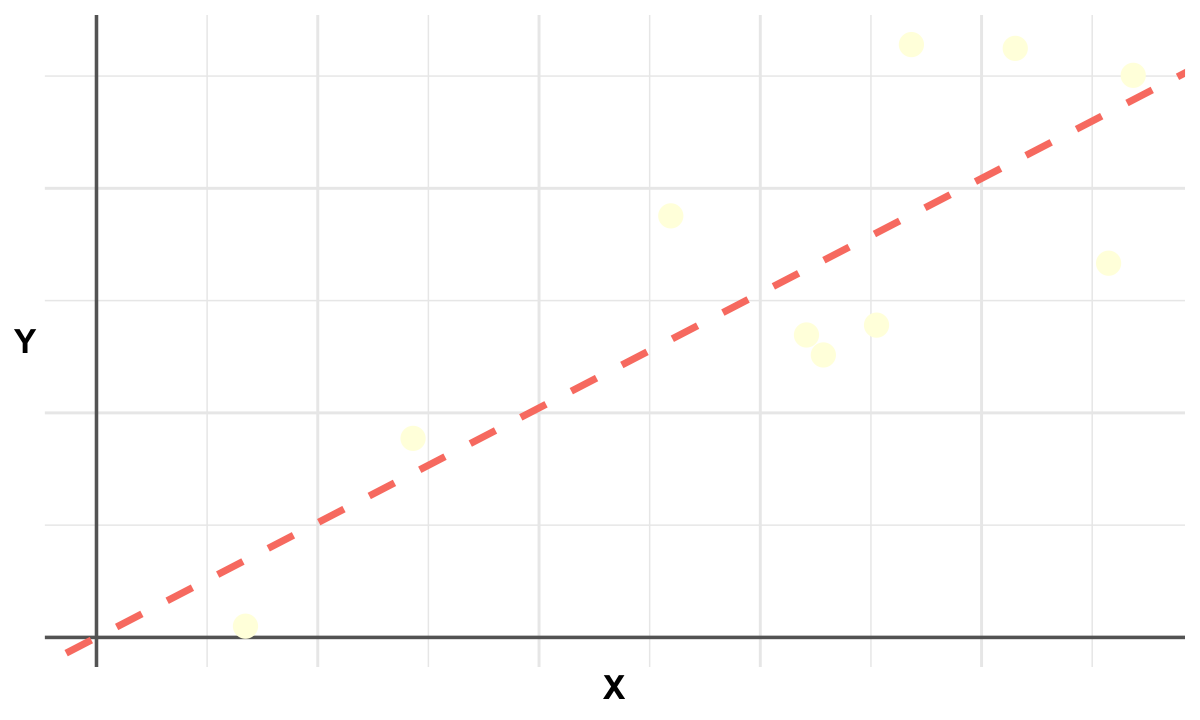

In [7]:
# Load necessary library
library(ggplot2)

options(repr.plot.width = 10, repr.plot.height = 6)

# Generate positive example data
set.seed(42)
x <- runif(10, min = 0, max = 5)  # Positive x values
y <- 0.5 * x + rnorm(10, mean = 0, sd = 1)
y <- y - min(y) + 0.1  # Ensure y is positive
data <- data.frame(x = x, y = y)

# Fit linear model through the origin
model <- lm(y ~ 0 + x, data = data)  # No intercept
beta1 <- coef(model)[1]

# Plot
p <- ggplot(data, aes(x = x, y = y)) +
  geom_hline(yintercept = 0, color = "gray40", linewidth = 1) +
  geom_vline(xintercept = 0, color = "gray40", linewidth = 1) +
  geom_point(color = "lightyellow", size = 6) +  # yellow points
  geom_abline(intercept = 0, slope = beta1, color = "salmon", linetype = "dashed", linewidth = 2) +
  labs(x = "X", y = "Y") +
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_blank(),  # no title
    axis.title = element_text(size = 20, face = "bold"),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title.y = element_text(angle = 0, vjust = 0.5)  # horizontal Y label
  )
print(p)

# Save with transparent background
ggsave("./figures/ordinary_least_squares.png", plot = p, 
       width = 6, height = 6, 
       bg = "transparent", 
       dpi = 300)
